## Anterior Model w. Complex Augmentations wo AHE/Contrast preprocessing

The following model utilizes cropped implant images subjected to monochromatic inversion (photometric interpretation corrections), complex augmentations such as contrast and hue adjustments but without preprocessing the pixel histogram of all images (ie w/o applying Adaptive histogram equalization and contrast stretching on the input dataset)

### Import Required Libraries

In [1]:
from albumentations import (
    Compose, OneOf, HorizontalFlip, VerticalFlip,Flip, ElasticTransform, ShiftScaleRotate, 
    JpegCompression, Blur, MotionBlur, CLAHE, RandomGamma, RandomContrast, 
    RandomBrightness, Resize, PadIfNeeded, CropNonEmptyMaskIfExists, 
    RandomCrop, IAAAdditiveGaussianNoise, IAAPerspective, IAASharpen,
    HueSaturationValue, Normalize, IAAAffine)
from albumentations.pytorch import ToTensor
import os
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from time import time
import cv2
from unet import UNet
import PIL
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pydicom
import re
import sklearn
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
from skimage import exposure
import glob
import torchvision
from PIL import Image
from statistics import mean
from torchvision.utils import make_grid
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
import seaborn as sn  # for heatmaps
import time
import copy
import augmentations as a
import helper_functions as hlp

### Input Parameters

In [96]:
no_brands = 4                                                            # No. of Brands
dcom_data_path = '/home/judy/devbox/cspine_hardware'                     # Filepath of DICOM files
ref_image_1 = pydicom.dcmread('Obsolete/IM-2275-0001.dcm')               # Reference Image
data_dir = '/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Jahangir/data_anterior_final_wo_proc_2/'
dataset_list = ['train', 'val', 'test']
population_mean = []
population_std = []
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

### Read in training, validation and testing data sets

In [97]:
# Reading train, validation and test sets
#train_set = pd.read_csv('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Jahangir/Train_DCM_Labels_Strat.csv')
#val_set = pd.read_csv('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Jahangir/Val_DCM_Labels_Strat.csv')
#test_set = pd.read_csv('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Jahangir/Test_DCM_Labels_Strat.csv')
train_set = pd.read_csv('Train_anterior_final_wo_proc_data.csv')
val_set = pd.read_csv('Val_anterior_final_wo_proc_data.csv')
test_set = pd.read_csv('Test_anterior_final_wo_proc_data.csv')

In [98]:
train_set.Label.value_counts()

1    646
2    243
3    140
4     14
Name: Label, dtype: int64

In [99]:
val_set.Label.value_counts()

1    180
2     43
3     20
4      3
Name: Label, dtype: int64

In [100]:
test_set.Label.value_counts()

1    225
2     79
3     40
4     10
Name: Label, dtype: int64

### Create train, val and test sets

In [101]:
x_train, y_train = hlp.generate_labels_feats(train_set, 'Label', 'filepath')
x_val, y_val = hlp.generate_labels_feats(val_set, 'Label', 'filepath')
x_test, y_test = hlp.generate_labels_feats(test_set, 'Label', 'filepath')

### Create Image Dataset

In [102]:
# Generate image dataset using augmentations without normalization: 
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x),
                                        a.apply_augmentations_wo_norm(x, 256, 0.25, 0.25,
                                                             0.1,0.5, 0, 5)) for x in dataset_list}

# Generate Data Loader with batch size 1:
train_loader = DataLoader(image_datasets['train'], batch_size = 1, shuffle = True, num_workers = 0)

#Store Batch Means and Standard Deviations: 
for i in range(len(train_loader.dataset.imgs)):
    inputs, classes = next(iter(train_loader))
    batch_mean = inputs[0][0].mean().item()
    batch_std = inputs[0][0].std().item()
    population_mean.append(batch_mean)
    population_std.append(batch_std)
    i += 1

avg_pop_mean = hlp.Average(population_mean)
avg_pop_std = hlp.Average(population_std)

### Generate Dataset

In [103]:
# Generate image dataset using augmentations with normalization: 
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x),
                                        a.apply_augmentations_with_norm(x, 256, 0.25, 0.25,
                                                             0.1,0.5, 0, 5, avg_pop_mean,
                                                                     avg_pop_std)) for x in dataset_list}

dataloaders = {x: DataLoader(image_datasets[x], batch_size = 10, shuffle = True, num_workers = 0)
              for x in dataset_list}

dataset_sizes = {x: len(image_datasets[x]) for x in dataset_list}
class_names = image_datasets['train'].classes


In [104]:
class_names

['1', '2', '3', '4']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: [    0     0     0     0     0     1     1     1     1     1]
Class:  1 1 1 1 1 2 2 2 2 2


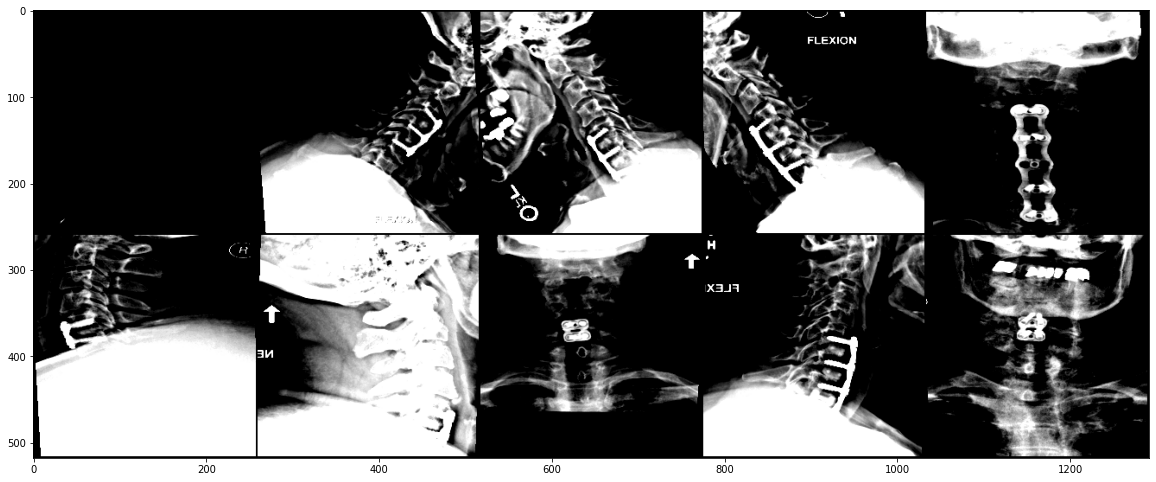

In [105]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in dataloaders['train']: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [106]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    
    for epoch in range(num_epochs):
        trn_corr = 0
        tst_corr = 0
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_correct.append(epoch_acc.item())
            elif phase == 'val':
                val_losses.append(epoch_loss)
                val_correct.append(epoch_acc.item())
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_correct,val_correct

In [107]:
def finetune_model(model, criterion, optimizer, scheduler, num_epochs, train_losses, val_losses, train_correct, val_correct):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses = train_losses
    val_losses = val_losses
    train_correct = train_correct
    val_correct = val_correct
    
    for epoch in range(num_epochs):
        trn_corr = 0
        tst_corr = 0
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_correct.append(epoch_acc.item())
            elif phase == 'val':
                val_losses.append(epoch_loss)
                val_correct.append(epoch_acc.item())
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_correct,val_correct

In [108]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
value_counts_ = y_train.value_counts().sort_index()
no_of_cats = len(value_counts_)
weightings = value_counts_.sum()/(value_counts_*no_of_cats).values
weightings = torch.FloatTensor(weightings) 
#criterion = nn.NLLLoss(weight = weightings).to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-6, momentum=0.9)

#optimizer_ft = optim.SGD(model_ft.parameters(), [
 #               {'params': model_ft.base.parameters()},
  #              {'params': model_ft.classifier.parameters(), 'lr': 1e-6}
   #         ], lr=1e-2, momentum=0.9)
optimizer_ft = torch.optim.Adam([
    {'params': list(model_ft.parameters())[:-1], 'lr': 1e-6},#, 'momentum': 0.9, 'weight_decay': 1e-4},
    {'params': list(model_ft.parameters())[-1], 'lr': 1e-4}#, 'momentum': 0.9, 'weight_decay': 1e-4}
])

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.003, steps_per_epoch=len(dataloaders['train']), epochs=10)
# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

In [109]:
# Total model parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    #for item in params:
        #print(f'{item:>6}')
    print(f'Total model parameters: {sum(params):>6}')
    
count_parameters(model_ft)

Total model parameters: 21286724


In [110]:
epochs= 10
model_ft,train_loss,val_loss, train_correct, val_correct = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=epochs)

Epoch 0/9
----------
train Loss: 0.8742 Acc: 0.6502
val Loss: 0.7391 Acc: 0.7189

Epoch 1/9
----------
train Loss: 0.4004 Acc: 0.8581
val Loss: 0.8228 Acc: 0.7235

Epoch 2/9
----------
train Loss: 0.2844 Acc: 0.9076
val Loss: 0.9020 Acc: 0.7788

Epoch 3/9
----------
train Loss: 0.2014 Acc: 0.9285
val Loss: 0.5194 Acc: 0.8341

Epoch 4/9
----------
train Loss: 0.1842 Acc: 0.9351
val Loss: 0.5432 Acc: 0.8295

Epoch 5/9
----------
train Loss: 0.1348 Acc: 0.9527
val Loss: 0.6313 Acc: 0.8018

Epoch 6/9
----------
train Loss: 0.1079 Acc: 0.9681
val Loss: 0.6321 Acc: 0.7926

Epoch 7/9
----------
train Loss: 0.0764 Acc: 0.9692
val Loss: 0.3663 Acc: 0.8986

Epoch 8/9
----------
train Loss: 0.0965 Acc: 0.9725
val Loss: 0.4766 Acc: 0.8571

Epoch 9/9
----------
train Loss: 0.0900 Acc: 0.9725
val Loss: 0.7020 Acc: 0.8018

Training complete in 11m 45s
Best val Acc: 0.898618


In [111]:
torch.save(model_ft.state_dict(), '/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Jahangir/Resnet34_ep10_ant_final_wo_5.pt')

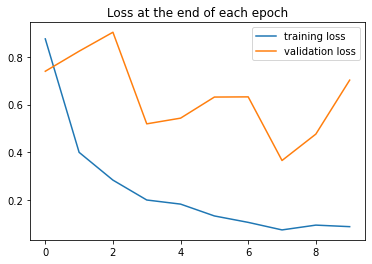

In [112]:
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

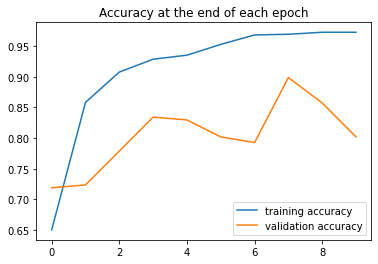

In [113]:
plt.plot(range(epochs),train_correct, label='training accuracy')
plt.plot(range(epochs), val_correct, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [114]:
model = models.resnet34(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)
model.load_state_dict(torch.load('Resnet34_ep10_ant_final_wo_5.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [115]:
class_names

['1', '2', '3', '4']

TRAINING SET METRICS
------------------------------------------------------------
Test accuracy:		0.9955995599559956
Balanced accuracy:	0.9942908199727527
Classification report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       558
           1       1.00      1.00      1.00       215
           2       0.99      0.98      0.99       122
           3       1.00      1.00      1.00        14

    accuracy                           1.00       909
   macro avg       1.00      0.99      1.00       909
weighted avg       1.00      1.00      1.00       909



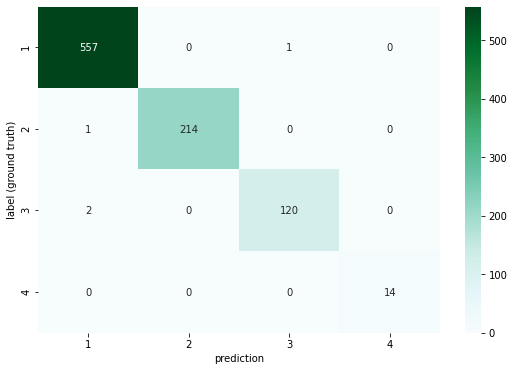

***TRAINING SET***
F1 score is 0.9955954229668423
Precision score is 0.9956022550306978
recall score is 0.9955995599559956
auc score is 0.9998383309770358
confusion_matrix score is:
[[  557     0     1     0]
 [    1   214     0     0]
 [    2     0   120     0]
 [    0     0     0    14]]


In [116]:

dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=False)
y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['train']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('TRAINING SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


f1_score, precision, recall, auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TRAINING SET***")
print(f'F1 score is {f1_score}')
print(f'Precision score is {precision}')
print(f'recall score is {recall}')
print(f'auc score is {auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

VALIDATION SET METRICS
------------------------------------------------------------
Test accuracy:		0.8986175115207373
Balanced accuracy:	0.6264069449196031
Classification report:

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       158
           1       0.94      0.92      0.93        37
           2       0.59      0.65      0.62        20
           3       0.00      0.00      0.00         2

    accuracy                           0.90       217
   macro avg       0.62      0.63      0.62       217
weighted avg       0.89      0.90      0.90       217



/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


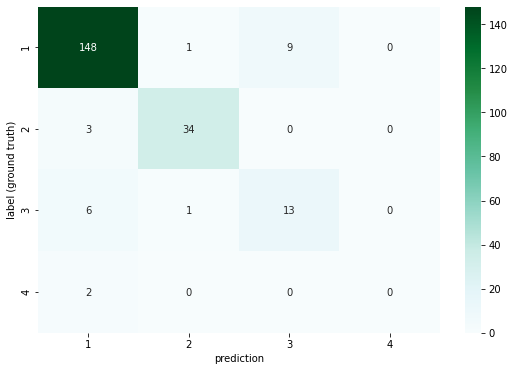

***VALIDATION SET***
F1 score is 0.8957595798801893
Precision score is 0.8932341412560525
recall score is 0.8986175115207373
auc score is 0.9419147888089267
confusion_matrix score is:
[[  148     1     9     0]
 [    3    34     0     0]
 [    6     1    13     0]
 [    2     0     0     0]]


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['val']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('VALIDATION SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])

f1_score, precision, recall, auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***VALIDATION SET***")
print(f'F1 score is {f1_score}')
print(f'Precision score is {precision}')
print(f'recall score is {recall}')
print(f'auc score is {auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

TEST SET METRICS
------------------------------------------------------------
Test accuracy:		0.7639344262295082
Balanced accuracy:	0.5027292152292152
Classification report:

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       195
           1       0.90      0.65      0.75        66
           2       0.38      0.47      0.42        36
           3       0.00      0.00      0.00         8

    accuracy                           0.76       305
   macro avg       0.53      0.50      0.51       305
weighted avg       0.77      0.76      0.76       305



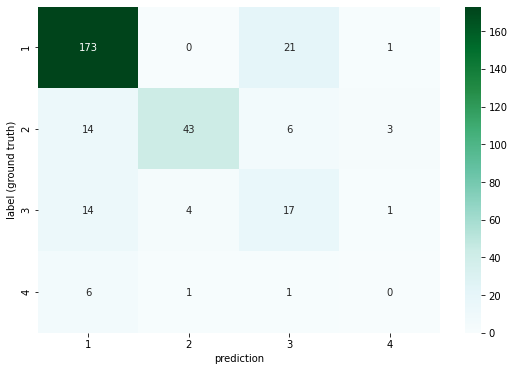

***TEST SET***
F1 score is 0.7630701825929311
Precision score is 0.7727738180090282
recall score is 0.7639344262295082
auc score is 0.8903891862973558
confusion_matrix score is:
[[  173     0    21     1]
 [   14    43     6     3]
 [   14     4    17     1]
 [    6     1     1     0]]


In [118]:
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
test_set = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['test']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        test_set.append(X_test)
        correct += (predicted == y_test).sum()
 
print('TEST SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))
#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


f1_score, precision, recall, auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TEST SET***")
print(f'F1 score is {f1_score}')
print(f'Precision score is {precision}')
print(f'recall score is {recall}')
print(f'auc score is {auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

In [23]:
def metrics_function(y_predicted, y_probs, y_true):
    '''
    This function takes an input of predictions and true values and returns weighted precision, recall, f1 scores,
    and AUC scores. 
    Inputs:
        y_predicted: NumPy array of shape (n_samples,) which contains predictions of categories
        y_probs: NumPy array of shape (n_samples, n_classes) which contains probabilities for each class
        y_true: NumPy array of shape (n_samples,) which contains actual labels for samples
    Outputs:
        f1_score: Weighted F1-score
        precision: Weighted Precision score
        recall: Weighted recall score
        auc: Weighted AUC score calculated using One-Versus-Rest Approach
        confusion_matrix: Confusion Matrix
    '''
    import sklearn.metrics
    from sklearn.preprocessing import OneHotEncoder
    import numpy as np
    
    params = {
        'y_true': y_true,
        'y_pred': y_predicted,
        'average': 'weighted'
    }
    f1_score = sklearn.metrics.f1_score(**params)
    precision = sklearn.metrics.precision_score(**params)
    recall = sklearn.metrics.recall_score(**params)
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true = y_true, y_pred = y_predicted)
    
    encoder = OneHotEncoder()
    y_encoded = encoder.fit_transform(np.array(y_true).reshape(-1,1))
    try:
        auc = sklearn.metrics.roc_auc_score(y_true = y_encoded.toarray(), y_score = y_probs, average='weighted', multi_class = 'ovr')
    except:
        auc = 0
    return f1_score, precision, recall, auc, confusion_matrix

In [ ]:
misses = np.array([])
for i in range(len(pred_list)):
    if pred_list[i] != y_test_list[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

# Display the first 10 index positions

print(misses[:50])
ten_misses =misses[:50]
print(ten_misses)
for i in ten_misses:
    print(f'Index: {i} and file name:', {image_datasets['test'].imgs[i]})
    #nextrow = next(row)
    lbls = y_test_list[i]
    pred = pred_list[i]
    print(f'Label:{lbls} and Prediction: {pred}')

    images = test_set[i].to('cpu')
    im = make_grid(images, nrow=ten_misses)
    plt.figure(figsize=(8,4))
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    plt.show(block=False)

In [ ]:
len(pred_list)